In [1]:
import pandas as pd
import openai
import base64
import numpy as np
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
human_data = pd.read_csv("data\\30_rocks_dimensions.csv", index_col=0)

In [3]:
human_data

,Category,Subtype,Token,MDS Dimension 1,MDS Dimension 2,MDS Dimension 3,MDS Dimension 4,MDS Dimension 5,MDS Dimension 6,MDS Dimension 7,...,Presense of Holes,Presence of Layers,Presence of Special Feature,Heterogeneity of Grain,Angular/Rounded Fragments,Curved/Straight Stripes,Munsell Value,Saturation,x',y'
1,Igneous,Andesite,6,-0.902,0.327,2.137,-1.029,0.203,-2.355,-2.638,...,0.16,0.05,0.05,3.65,3.75,5.00,5.65,0.4,-0.02,-0.03
2,Igneous,Basalt,2,-1.926,-2.603,-1.559,-0.680,0.852,-1.680,-3.187,...,0.00,0.11,0.11,2.25,4.95,5.00,4.80,0.7,-0.04,-0.04
3,Igneous,Diorite,10,-0.268,1.974,2.797,-0.685,1.564,-0.742,0.564,...,0.05,0.00,0.05,3.35,4.40,5.00,7.05,1.9,-0.04,0.18
4,Igneous,Gabbro,3,-1.907,2.106,0.299,-0.051,1.624,-1.712,-1.521,...,0.05,0.00,0.05,3.35,4.25,5.00,4.35,1.0,0.05,0.06
5,Igneous,Granite,11,1.651,2.829,0.731,0.681,0.673,0.306,-0.296,...,0.05,0.00,0.05,5.05,3.75,5.00,7.80,2.0,0.12,0.15
6,Igneous,Obsidian,9,-4.519,-3.471,-1.293,3.766,-0.404,0.371,-0.796,...,0.00,0.21,0.21,3.45,4.85,5.80,2.00,0.6,-0.02,0.05
7,Igneous,Pegmatite,1,-0.205,1.769,1.948,1.885,-3.238,1.793,3.096,...,0.11,0.05,0.21,7.25,3.55,5.05,4.95,2.7,0.10,0.19
8,Igneous,Peridotite,11,-0.685,0.835,4.708,-0.573,-0.710,1.025,0.595,...,0.74,0.00,0.00,4.60,4.65,5.00,5.50,3.0,-0.08,0.26
9,Igneous,Pumice,6,2.097,-1.228,2.976,-1.869,1.433,4.872,-0.149,...,1.00,0.00,0.00,3.85,4.95,4.55,7.15,3.4,0.15,0.29
10,Igneous,Rhyolite,11,0.658,-4.026,-0.860,-2.507,0.174,-1.694,-2.461,...,0.00,0.16,0.00,2.40,5.15,4.25,6.25,0.9,0.03,-0.06


In [4]:
client = openai.OpenAI(
  organization='org-LewILTfUI8Y9pb57686FCqdy',
  project='proj_fPgG23M7oU6YDmEKQRAc5H7y',
)

In [5]:
# Function to encode the image
def encode_image(image):
  image_path = f"data\\360 Rocks\\{image}.jpg"
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')  


In [6]:
SEED = 123

In [7]:
lightness = ("Lightness of Color", "light or dark", "very dark", "very light", "S_BITUMINOUS COAL_09", "M_MARBLE_04", "is made up of mostly dark colors like black or mostly light colors like white")
grain_size = ("Grain Size", "fine-grained or coarse-grained", "very fine-grained", "very coarse-grained", "I_OBSIDIAN_09", "S_BRECCIA_11", "is made up of fine, possibly imperceptible particles or is made up of coarse chunks")
roughness = ("Roughness", "smooth or rough", "very smooth", "very rough", "S_CHERT_03", "I_PUMICE_06", "has a smooth, flat texture or has a rough, bumpy texture")
shininess = ("Shininess", "dull or shiny", "very dull", "very shiny", "I_RHYOLITE_11", "M_ANTHRACITE_12", "is dull and matte or shiny and sparkly")
organization = ("Organization", "unstructured or organized", "composed of unstructured framgents", "composed of organized stripes, layers, or grains", "S_CONGLOMERATE_03", "M_GNEISS_07", "is composed of disorganized fragments put together haphazardly, or is made up of stripes, layers, or grains organized in a regular fashion")
saturation = ("Saturation", "desaturated or saturated", "very desaturated and uncolorful", "very saturated and vibrant", "I_ANDESITE_06", "S_SANDSTONE_12", "is gray and lacking color or is vibrant and colorful")

In [8]:
def create_messages(dimension, rock):
    dim_name, adjective, low_value, high_value, low_ex, high_ex, long_description = dimension
    system_prompt = (
    "You are a participant in a study in which you are shown images of rocks and "
    f"must rate them on their {dim_name.lower()}, which refers to whether the rock " 
    f"{long_description}. Make your ratings on a 1-9 scale, with 1 being {low_value} "
    f"and 9 being {high_value}. Try to use the full range of the scale. "
    "Only respond with a single number from 1 to 9. Do not explain your reasoning."
    )
    messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",
       "content": [{"type": "text", "text": f"This is an example of a rock that is {low_value}."},
         {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{encode_image(low_ex)}"
            },
          }
        ]
    },
    {"role": "user",
       "content": [{"type": "text", "text": f"This is an example of a rock that is {high_value}."},
         {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{encode_image(high_ex)}"
            },
          }
        ]
    },
    {"role": "user",
       "content": [
          {"type": "text", "text": f"How {adjective} is this rock?"},
          {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image(rock)}"
              },
          }
        ]
    }
    ]
    return messages

In [9]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(10))
def completion_with_backoff(**kwargs):
    return client.chat.completions.create(**kwargs)

In [10]:
def get_responses(dimension, rock): 
  response = completion_with_backoff(
    model="gpt-4o",
    messages=create_messages(dimension, rock),
    logprobs=True,
    top_logprobs=20,
    seed=SEED,
    max_tokens=1,
  )
  return response

In [11]:
def get_average_rating(logprobs):
    word2num = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9}
    ratings = np.array([i+1 for i in range(9)])
    weights = np.array([0.]*9)
    for lp in logprobs:
        token = lp.token.lower()
        i = word2num.get(token, token)
        try:
            i = int(i) - 1
            weights[i] += np.exp(lp.logprob)
        except:
            continue
    try:
        av = np.average(ratings, weights=weights)
    except:
        av = 0.0
    return av


In [23]:
results = []
for dim in [lightness, grain_size, roughness, shininess, organization]:
    for _, row in human_data.iterrows():
        rock = f"{row['Category'][0]}_{row['Subtype']}_{str(row['Token']).zfill(2)}"
        human = row[dim[0]]

        response = get_responses(dim, rock)
        logprobs = response.choices[0].logprobs.content[0].top_logprobs
        chatgpt = get_average_rating(logprobs)

        results.append({"Rock": rock, "Dimension": dim[0], "Human Rating": human, "ChatGPT Rating": chatgpt, "Response": response})

results = pd.DataFrame(results)

In [26]:
results.to_csv("chatgpt_ratings.csv", index=False)

In [25]:
results

,Rock,Dimension,Human Rating,ChatGPT Rating,Response
0,I_Andesite_06,Lightness of Color,5.85,4.975000,ChatCompletion(id='chatcmpl-9TeyytbpMkisZpTNOT...
1,I_Basalt_02,Lightness of Color,4.80,2.244897,ChatCompletion(id='chatcmpl-9Tez1C7Y2NJAINkZlE...
2,I_Diorite_10,Lightness of Color,6.20,5.057032,ChatCompletion(id='chatcmpl-9Tez4bftxc9UNeJHdC...
3,I_Gabbro_03,Lightness of Color,4.50,4.675637,ChatCompletion(id='chatcmpl-9Tez8QrQjiuqm44tRM...
4,I_Granite_11,Lightness of Color,7.00,5.762493,ChatCompletion(id='chatcmpl-9TezCdgmolhgorBZuZ...
...,...,...,...,...,...
25,S_Micrite_09,Saturation,4.10,3.125434,ChatCompletion(id='chatcmpl-9TewUCe9sIgiBBFrqA...
26,S_Rock Gypsum_02,Saturation,0.40,1.922823,ChatCompletion(id='chatcmpl-9TewZest8nOuaFYm3J...
27,S_Rock Salt_12,Saturation,0.40,1.638808,ChatCompletion(id='chatcmpl-9TewdeuBtYY2mWX7vb...
28,S_Sandstone_12,Saturation,5.40,8.235300,ChatCompletion(id='chatcmpl-9Tewh9bTBO4XbSd5AK...


Text(0.5, 1.0, 'Lightness of Color')

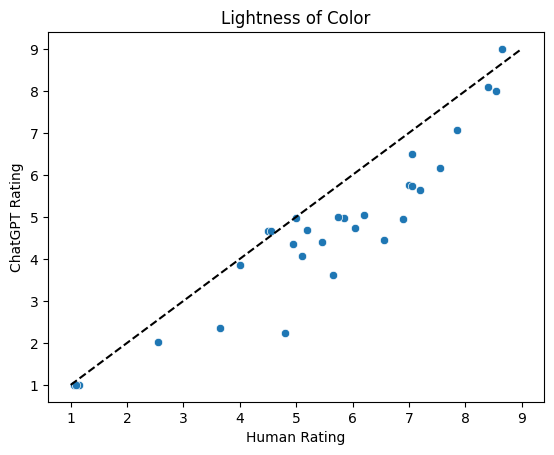

In [27]:
sns.scatterplot(results[results["Dimension"] == "Lightness of Color"], x="Human Rating", y="ChatGPT Rating")
plt.plot([1, 9], [1, 9], 'k--')
plt.title("Lightness of Color")

Text(0.5, 1.0, 'Grain Size')

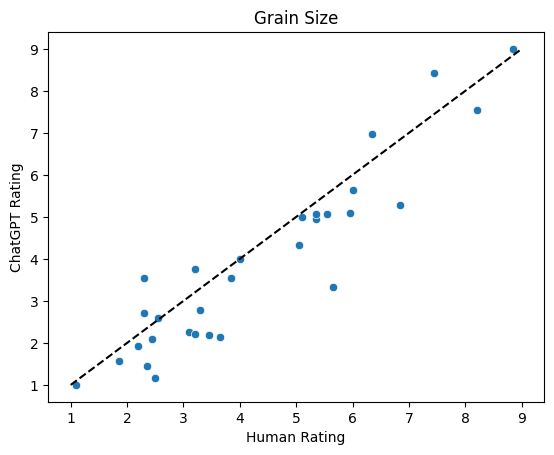

In [28]:
sns.scatterplot(results[results["Dimension"] == "Grain Size"], x="Human Rating", y="ChatGPT Rating")
plt.plot([1, 9], [1, 9], 'k--')
plt.title("Grain Size")

Text(0.5, 1.0, 'Roughness')

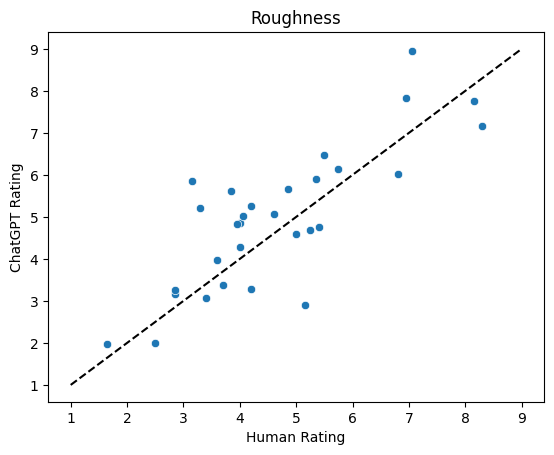

In [29]:
sns.scatterplot(results[results["Dimension"] == "Roughness"], x="Human Rating", y="ChatGPT Rating")
plt.plot([1, 9], [1, 9], 'k--')
plt.title("Roughness")

Text(0.5, 1.0, 'Shininess')

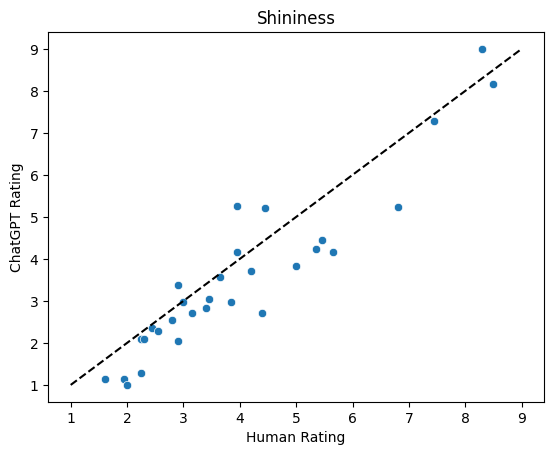

In [30]:
sns.scatterplot(results[results["Dimension"] == "Shininess"], x="Human Rating", y="ChatGPT Rating")
plt.plot([1, 9], [1, 9], 'k--')
plt.title("Shininess")

Text(0.5, 1.0, 'Organization')

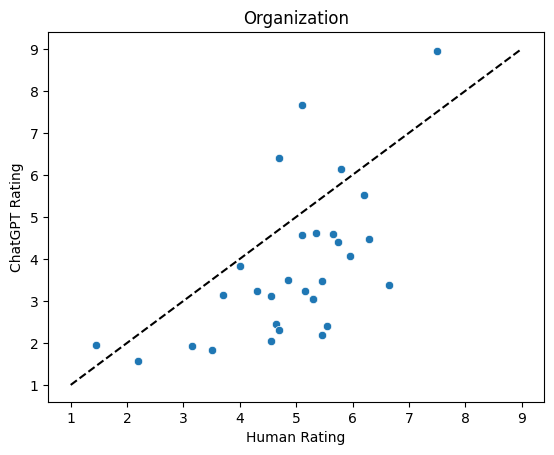

In [31]:
sns.scatterplot(results[results["Dimension"] == "Organization"], x="Human Rating", y="ChatGPT Rating")
plt.plot([1, 9], [1, 9], 'k--')
plt.title("Organization")

Text(0.5, 1.0, 'Saturation')

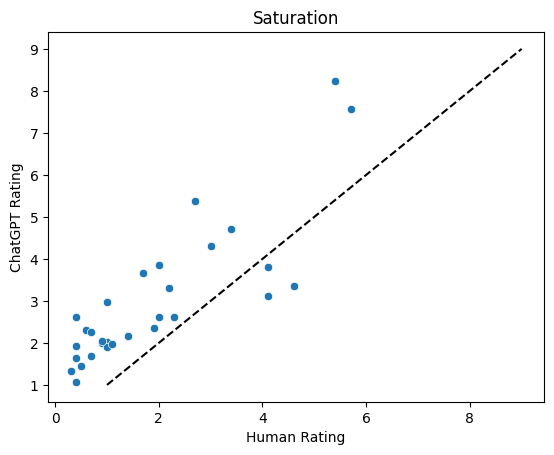

In [32]:
sns.scatterplot(results[results["Dimension"] == "Saturation"], x="Human Rating", y="ChatGPT Rating")
plt.plot([1, 9], [1, 9], 'k--')
plt.title("Saturation")

In [33]:
results.groupby("Dimension").corr(numeric_only=True)

Human Rating  ChatGPT Rating
Dimension                                                      
Grain Size         Human Rating        1.000000        0.932649
                   ChatGPT Rating      0.932649        1.000000
Lightness of Color Human Rating        1.000000        0.935616
                   ChatGPT Rating      0.935616        1.000000
Organization       Human Rating        1.000000        0.601160
                   ChatGPT Rating      0.601160        1.000000
Roughness          Human Rating        1.000000        0.804090
                   ChatGPT Rating      0.804090        1.000000
Saturation         Human Rating        1.000000        0.847119
                   ChatGPT Rating      0.847119        1.000000
Shininess          Human Rating        1.000000        0.935216
                   ChatGPT Rating      0.935216        1.000000